# Pressure

## Introduction

All events and actions in the game are dynamical. One of the key predictors of successfulness of actions in soccer is the pressure applied by the opponents. The same pass/shot/dribble can be successful or not depending on the pressure applied by the opponents. Different methodologies have been proposed to measure the pressure applied by the opponents. In this notebook, I will show how to measure the pressure applied by the opponents using the methods of Herold et al. 2022: Off-ball behavior in association football: A data-driven model to measure changes in individual defensive pressure. Later studies have confirmed that this methodology is one of the key indicators for ball turnovers in soccer. The methodology is almost similar to the one propes by Andrienko et al. 2017 Visual analysis of pressure in football. However, the methodology of Herold et al. 2022 acknowledges the importance of the location on the pitch.

```{warning}
Although we try to keep everything up to date, the code in this notebook might not perfectly align with the code in the package. If you find any bugs or have any suggestions, please let us know.
```

## Methodology

The pressure is essentially the sum of the pressure applied by each opponent. The pressure applied by each opponent is calculcated based on the location of the defender relative to the attacker, each defender can apply maximal 100% pressure when he is exactly at the same location as the attacker. The attacker gets a oval shape area around him which is directed towards the opponent goal. The closer you are in this area, the higher the pressure. Combining all this, the model acknowledges that pressure is higher when the attacker is directly in front of the attacker, and lower if the defender is behind the attacker.

<div align="center">
    <img src="https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcQ1G1dhaYREmm8Jl1_IdtmntRgJX0c6Kz3luGm99QL_D8myJv8y" width=650/>
</div>

## Calculation of Pressure by Andrienko et al. 2017

The pressure applied by each defender is calculated as follows:

1. The sum of the pressure applied by all defenders: 

$$P_{total} = \sum_{i=1}^{N} P_{i}$$ 

Where $N$ is the number of defenders and $P_{i}$ is the pressure applied by defender $i$.

2. The pressure applied by each defender:

$$P_{i} = (1-d_{i}/L)^{q} * 100% $$ 

Where $d_{i}$ is the distance between the attacker and defender $i$, $L$ is the distance limit as determined in the next step and $q$ is a parameter that can be adjusted. $q$ is the quadratic parameter that determines how fast the pressure decreases with distance.

3. The limit distance $L$ is calculated as follows: 

$$L = D_{back}+(D_{front} - D_{back})(z^{3}+0.3z)/1.3$$ 

Where $D_{back}$ and $D_{front}$ are the constants that determine the lenght of the oval shape. Lastly, $z$, as determined in the next step, incorperates the angle of the defender relative to the attacker.

4. The factor of the angle $z$ is calculated as follows: 

$$z = (1 - cos{\theta})/2$$ 

Where $\theta$ is the angle between the attacker and defender $i$.

The constants proposed by Andrienko et al. 2017 are $D_{back} = 3.0$, $D_{front} = 9.0$ and $q = 1.75$.

## Addition of Herold et al. 2022

Because the $D_{front}=9.0$ in the methodology of Andrienko, the attacker are almost always under high pressure. Herold et al. proposed to make the $D_{front}$ dynamic based on the location of the attacker on the pitch. The $D_{front}$ lowers with 5% each 5 meters the attacker is closer to the goal. 

$$D_{front} = 9.0 - 0.05 * (105.0 - D_{goal})$$

Where $D_{goal}$ is the distance between the attacker and the goal and $105$ is the length of a soccer pitch in meters.

## The code

Okay, enough formulas. Let's code this up.



In [2]:
import pandas as pd
import numpy as np
from databallpy.features import get_smallest_angle
import math
import matplotlib.pyplot as plt
import pandas as pd
from databallpy.visualize import plot_soccer_pitch
from matplotlib.patches import Ellipse

In [3]:
def calculate_z(
    td_frame: pd.Series,
    column_id: str,
    opponent_column_id: str,
    pitch_length: float = 105.0,
) -> float:
    """
    Calculates the z value in accordance with the article of Adrienko et al (2016).
    Note that the angle calculation is slightly different here, therefore the formula is
    not z = (1 - cos(phi))/2, but z = (1 + cos(phi))/2. Phi is the angle between the
    direction of the player to the target (goal), and the vector of the opponent to the
    player.

    Args:
        td_frame (pd.Series): Tracking data frame of all players.
        column_id (str): Column name of the player for which to calculate the pressure.
        opponent_column_id (str): Column name of the player which is pressuring the
            player.
        pitch_length (float): Length (x-direction) of the pitch. Defaults to 105.0.

    Returns:
        float: z value of the pressure calculation.
    """
    team = column_id[:4]

    goal_xy = [pitch_length / 2, 0] if team == "home" else [-pitch_length / 2, 0]
    opponent_xy = [
        td_frame[opponent_column_id + "_x"],
        td_frame[opponent_column_id + "_y"],
    ]
    player_xy = [td_frame[column_id + "_x"], td_frame[column_id + "_y"]]

    player_goal_vec = [goal_xy[0] - player_xy[0], goal_xy[1] - player_xy[1]]

    player_opponent_vec = [opponent_xy[0] - player_xy[0], opponent_xy[1] - player_xy[1]]

    angles = get_smallest_angle(
        player_goal_vec, player_opponent_vec, angle_format="radian"
    )

    return (1.0 + np.cos(angles)) / 2.0

def calculate_L(d_back: float, d_front: float, z: float) -> float:
    """
    Calculates the L value of the pressure calculation in accordance with Adrienko et al. (2016).

    Args:
        d_back (float): Maximal distance to back from where pressure can be measured.
        d_front (float): Maximal distance in front of which pressure can be measured.
        z (list of float): Float values in accordance with formulas in Adrienko et al. (2016).

    Returns:
        float: L value of the pressure calculation.
    """
    L = d_back + (d_front - d_back) * ((z**3 + 0.3 * z) / 1.3)
    L = np.maximum(L, 0.0001)  
    return L

def calculate_variable_dfront(
    td_frame: pd.Series,
    column_id: str,
    max_d_front: float = 9.0,
    pitch_length: float = 105.0,
) -> float:
    """
    Calculates d_front over time according to Herold et al 2022.

    This function is based on the article "Off-ball behavior in association football: 
    A data-driven model to measure changes in individual defensive pressure".

    Args:
        td_frame (pd.Series): Tracking data frame of all players.
        column_id (str): Column name of the player for which to calculate the pressure.
        max_d_front (float): Maximal d_front, 9 meters according to the article.
        pitch_length (float): Length (x-direction) of the pitch.

    Returns:
        float: The pressure on the player.
    """

    team = column_id[:4]
    goal_xy = [pitch_length / 2, 0] if team == "home" else [-pitch_length / 2, 0]
    player_xy = [td_frame[column_id + "_x"], td_frame[column_id + "_y"]]
    player_goal_distance = math.dist(goal_xy, player_xy)

    return max_d_front - 0.05 * (pitch_length - player_goal_distance)

Looks like we are almost there, the final step is to calculate and sum the pressure applied by each defender!

In [4]:
def get_pressure_on_player(
    td_frame: pd.Series,
    column_id: str,
    *,
    pitch_size: list[float, float],
    d_front: str | float = "variable",
    d_back: float = 3.0,
    q: float = 1.75,
):
    """
    Calculates the pressure on a single player in accordance with "Visual 
    Analysis of Pressure in Soccer", Adrienko et al (2016).

    This function determines pressure as the sum of pressure from all opponents, 
    which depends on the angle and distance to the player. It calculates the 
    pressure for a single player using tracking data.

    Args:
        td_frame (pd.Series): Tracking data frame of all players.
        column_id (str): Column name of the player to analyse.
        pitch_size (list): Length and width of the pitch.
        d_front (numeric or str): Distance in meters of the front of the pressure oval. 
            If "variable", d_front will be variable based on the location on the field, 
            as described by Mat Herold et al (2022).
        d_back (float): Distance in meters of the back of the pressure oval.
        q (float): Quotient of how fast pressure increases/decreases as distance to the 
        player changes.

    Returns:
        numpy array: Pressure on the player over the length of the dataframe.
    """
    if d_front == "variable":
        d_front = calculate_variable_dfront(
            td_frame, column_id, pitch_length=pitch_size[0]
        )

    team = column_id[:4]
    opponent_team = "away" if team == "home" else "home"
    attacker_xy = [td_frame[column_id + "_x"], td_frame[column_id + "_y"]]

    tot_pressure = 0
    for opponent_column_id in [
        x[:-2] for x in td_frame.index if opponent_team in x and "_x" in x
    ]:
        defender_xy = [
            td_frame[opponent_column_id + "_x"],
            td_frame[opponent_column_id + "_y"],
        ]
        
        player_opponent_distance = math.dist(attacker_xy, defender_xy)
        # opponent not close enough to apply pressure on the player
        if player_opponent_distance > max([d_front, d_back]):
            continue

        z = calculate_z(
            td_frame, column_id, opponent_column_id, pitch_length=pitch_size[0]
        )
        L = calculate_L(d_back, d_front, z)

        current_pressure = (
            pd.to_numeric((1 - player_opponent_distance / L), errors="coerce").clip(
                0
            )
            ** q
            * 100
        )

        current_pressure = 0 if pd.isnull(current_pressure) else current_pressure
        tot_pressure += current_pressure

    return tot_pressure


## Visualisation of pressure

Lets create some fictional data and plot it to see how the pressure changes in different scenarios.

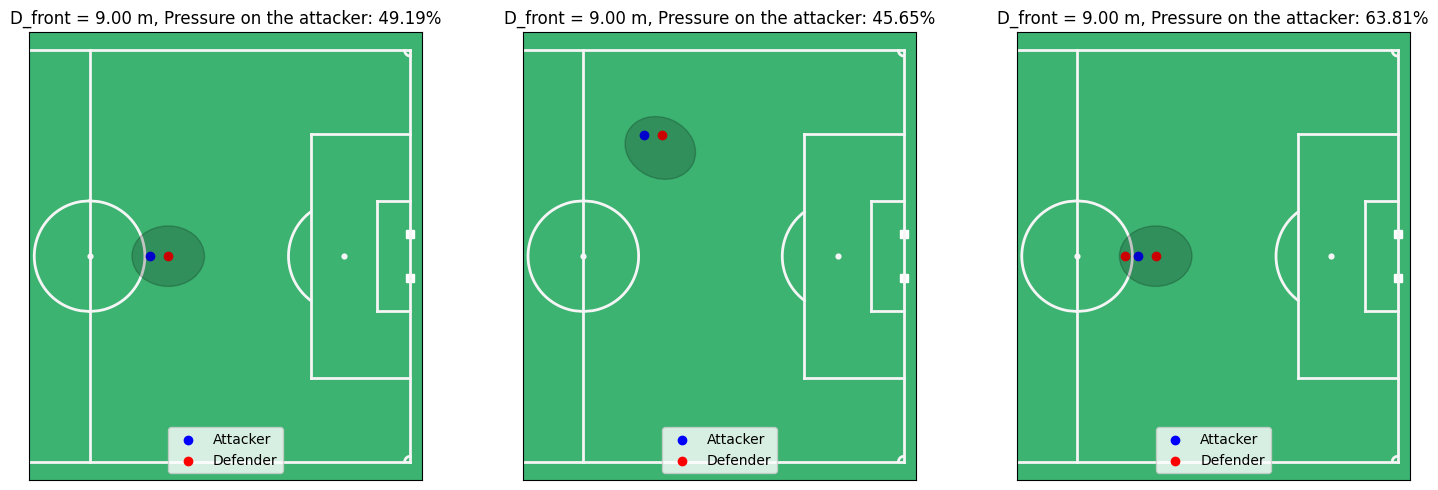

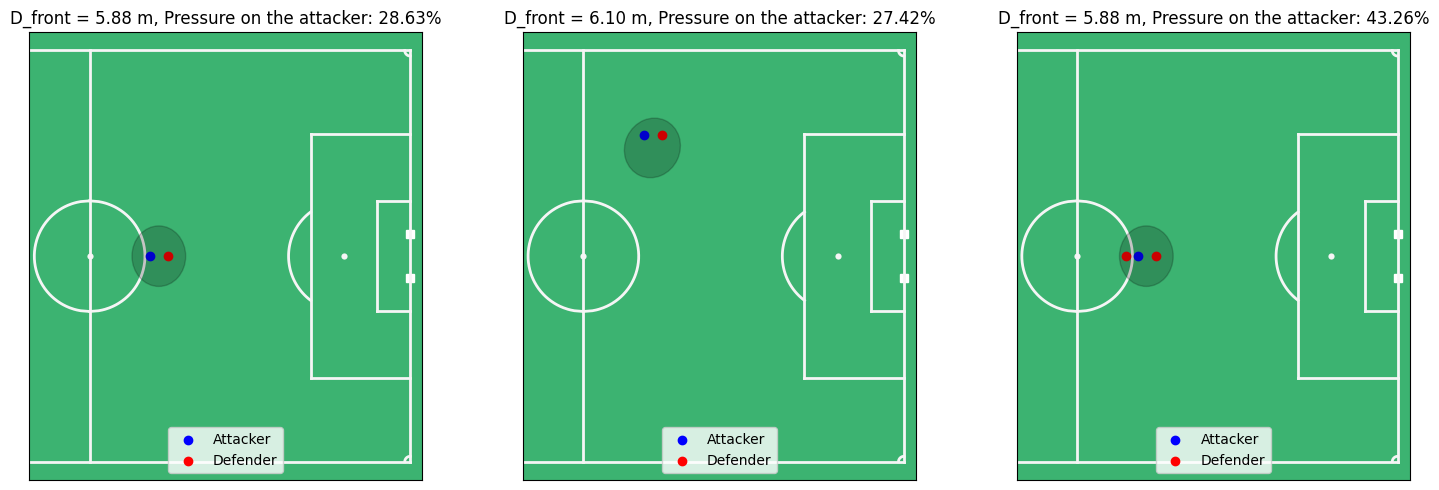

In [5]:
def plot_pressure_scenario(frame, player_id, ax, d_front, pitch_size=[105, 68]) -> plt.Axes:
    """
    Plots the pressure scenario for a given player and frame.
    
    Args:
        frame (pd.Series): The data frame containing player positions.
        player_id (str): The ID of the player to analyze.
        ax (matplotlib.axes.Axes): The axes object to plot on.
        d_front (float or str): The distance in front for pressure calculation or "variable".
        pitch_size (list): The dimensions of the pitch.

    returns:
        matplotlib.axes.Axes: The axes object with the plot.
    """
    pressure = get_pressure_on_player(frame, player_id, pitch_size=pitch_size, d_front=d_front)
    
    if d_front == "variable":
        d_front = calculate_variable_dfront(frame, player_id, pitch_length=pitch_size[0])
    
    ax.scatter(frame[f"{player_id}_x"], frame[f"{player_id}_y"], color="blue", label="Attacker")
    for col in [col for col in frame.index if col.startswith("away") and "_x" in col]:
        ax.scatter(frame[col], frame[col.replace("_x", "_y")], color="red", label="Defender" if 'away_2_x' in col else None)
    
    ax.set_title(f"D_front = {d_front:.2f} m, Pressure on the attacker: {pressure:.2f}%")
    ax.legend(loc="lower center")
    ax.set_xlim(-10, 55)
    ax.set_aspect("equal")

    elipse = create_elipse(frame[f"{player_id}_x"], frame[f"{player_id}_y"], d_front, 3.0)
    ax.add_artist(elipse)

    return ax

def create_elipse(x, y, d_front, d_back):
    """
    Creates an elipse patch for the pressure plot.
    
    Args:
        x (float): The x-coordinate of the player.
        y (float): The y-coordinate of the player.
        d_front (float): The distance in front of the player.
        d_back (float): The distance behind the player.
    
    Returns:
        matplotlib.patches.Ellipse: The elipse patch.
    """

    attacker_goal_vector = np.array([53-x, 0-y])
    angle = get_smallest_angle(attacker_goal_vector, [0, 0], angle_format="degree")

    total_length = d_front + d_back
    x_relative_to_centre = total_length / 2 - d_back
    x_elips = x + x_relative_to_centre * np.cos(np.radians(-angle))

    total_width = 10
    y_elips = y + total_width / 2 * np.sin(np.radians(-angle))

    elipse = Ellipse((x_elips, y_elips), total_length, total_width, angle=-angle, color="black", alpha=0.2)
    return elipse

fictional_frames = [
    pd.Series({"home_1_x": 10, "home_1_y": 0, "away_2_x": 13, "away_2_y": 0}, name="Fictional Frame 1"),
    pd.Series({"home_1_x": 10, "home_1_y": 20, "away_2_x": 13, "away_2_y": 20}, name="Fictional Frame 2"),
    pd.Series({"home_1_x": 10, "home_1_y": 0, "away_2_x": 13, "away_2_y": 0, "away_3_x": 8, "away_3_y": 0}, name="Fictional Frame 3")
]

for d_front in [9.0, "variable"]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, frame in zip(axes, fictional_frames):
        fig, ax = plot_soccer_pitch(fig=fig, ax=ax)
        ax = plot_pressure_scenario(frame, "home_1", ax, d_front)
    fig.tight_layout()

plt.show()

Lets look at the differences between these plots:

1. In the top row, the $D_{front}$ is fixed at 9.0, while in the bottom row, the $D_{front}$ is dynamic based on the location of the attacker. As you can see, the elips is much smaller in the bottom row compared to the top row. Therefore, the defender is relatively less far in the Elipse, and thus the pressure is lower. 

2. If we compare the first and second column, we can see that the distance between the attacker and the defender is exactly the same. However, since the defender comes from an angle instead of directly in front of the attacker, the pressure is lower in the second column. 

3. If we compare the first and the third column, we can see that the pressure of both defenders is summed up. However, notice that the pressure applied from the fist defender is higher than the second defender even though the second defender is closer to the attacker. This is because the second defender is approaching the attacker from the back.

4. If we compare the $D_{front}$ within the second row, we can see that it is adaptive to the location of the attacker. In the second column, the attacker is further away from the goal, thus the $D_{front}$ is higher. This results in a lower pressure compared to the third column where the attacker is closer to the goal.

# Pressure in DataBallPy

In DataBallPy you can simply import the `get_pressure_on_player` function from the `features` module. Let's see how we could use it in practice. For this example we will show how different passes are performend under different pressure levels. This is a very important nuance to include in your analysis if you wish the model the outcome of a pass or value a player based on his passing ability.

```python
from databallpy import get_match, get_open_match

match = get_match(
  tracking_data_loc="../data/tracking_data.dat",
  tracking_metadata_loc="../data/tracking_metadata.xml",
  tracking_data_provider="tracab"
  event_data_loc="../data/event_data_f24.xml",
  event_metadata_loc="../data/event_metadata_f7.xml",
  event_data_provider="opta",
)

# or get the open match provided by Metrica
match = get_open_match()
```

```{note}
The current supported tracking data providers are:

- Tracab
- Metrica
- Inmotio

The current supported event data provider are:
- Opta
- Metrica
- Instat

If you wish to use a different provider that is not listed here, please open an issue [here](https://github.com/Alek050/databallpy/issues)
```

In [6]:
from databallpy import get_saved_match
import os

match = get_saved_match("synced_match", os.path.join(os.getcwd(), "../saved_matches"))

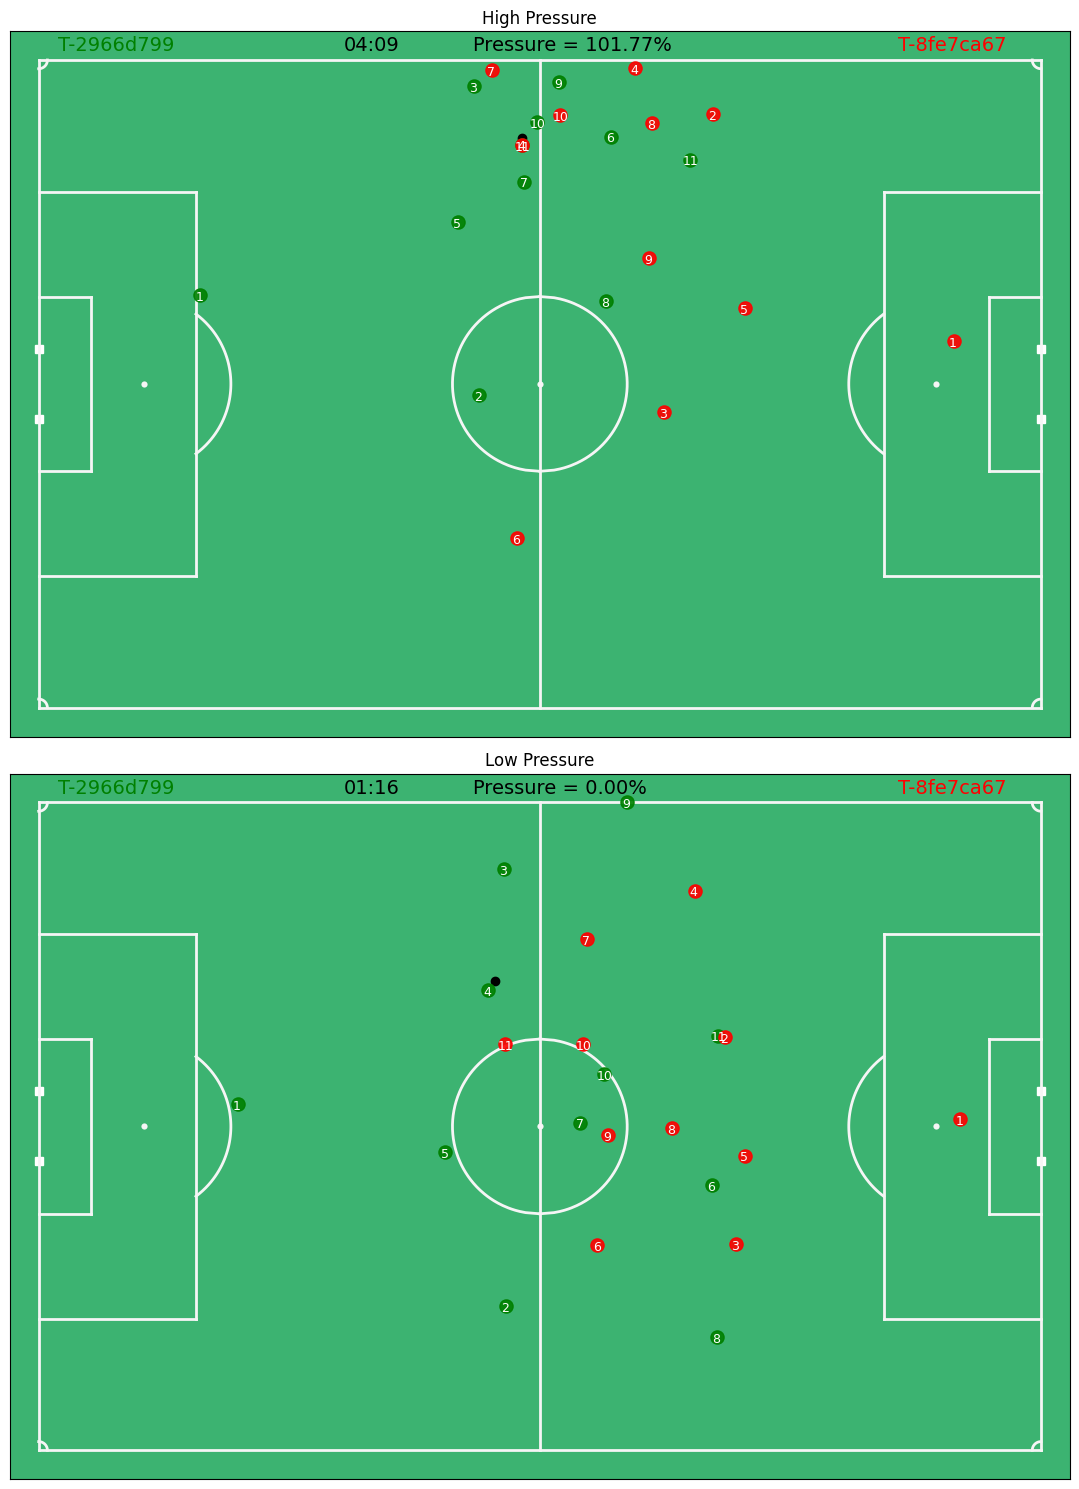

In [7]:
from databallpy.features import get_pressure_on_player
from databallpy.visualize import plot_tracking_data

match.passes_df["pressure"] = np.nan
for pass_ in match.pass_events.values():
    td_frame = match.tracking_data[match.tracking_data["event_id"]==pass_.event_id].iloc[0]
    pressure = get_pressure_on_player(
        td_frame=td_frame,
        column_id=match.player_id_to_column_id(pass_.player_id),
        pitch_size=match.pitch_dimensions,
        d_front="variable",
        d_back=3.0,
        q=1.75,
    )
    match.passes_df.loc[match.passes_df["event_id"]==pass_.event_id, "pressure"] = pressure

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 15))
fig, ax1 = plot_soccer_pitch(field_dimen=match.pitch_dimensions, ax=ax1, fig=fig)
fig, ax2 = plot_soccer_pitch(field_dimen=match.pitch_dimensions, ax=ax2, fig=fig)

high_pressure_pass_id = match.passes_df.loc[match.passes_df["pressure"] == match.passes_df["pressure"].max(), "event_id"].values[0]
low_pressure_pass_id = match.passes_df.loc[match.passes_df["pressure"] == match.passes_df["pressure"].min(), "event_id"].values[3]

high_pressure_frame = match.tracking_data[match.tracking_data["event_id"]==high_pressure_pass_id].index[0]
low_pressure_frame = match.tracking_data[match.tracking_data["event_id"]==low_pressure_pass_id].index[0]

fig, ax1 = plot_tracking_data(
    match, 
    high_pressure_frame, 
    ax=ax1, 
    fig=fig, 
    variable_of_interest=f"Pressure = {match.passes_df.loc[match.passes_df['event_id']==high_pressure_pass_id, 'pressure'].values[0]:.2f}%",
    title="High Pressure"
    )
fig, ax2 = plot_tracking_data(
    match, 
    low_pressure_frame, 
    ax=ax2, 
    fig=fig, 
    variable_of_interest=f"Pressure = {match.passes_df.loc[match.passes_df['event_id']==low_pressure_pass_id, 'pressure'].values[0]:.2f}%",
    title="Low Pressure"
    )

ax1.set_aspect("equal")
ax2.set_aspect("equal")
fig.tight_layout()

plt.show()

As you can see, the first pass is performed under high pressure. One of the defenders is almost at the same location of as the attacker. On top of that, another defender is nearby which increases the pressure to over 100%. The second pass is performed under lower pressure. There is no defender nearby or in front of the attacker. 

# Conclusion

In this notebook, we have shown how to calculate the pressure applied by the opponents using the methodology of Herold et al. 2022. The pressure is calculated based on the location of the defender relative to the attacker. The pressure is higher when the attacker is directly in front of the attacker, and lower if the defender is behind the attacker. The pressure is calculated by summing the pressure applied by each defender. The pressure applied by each defender is calculated based on the distance between the attacker and defender, the angle of the defender relative to the attacker and the distance between the attacker and the goal. The pressure is a key predictor of successfulness of actions in soccer.